In [3]:
import pandas as pd
import numpy as np

# 데이터 시각화 패키지
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns


# grhpviz
from sklearn.tree import export_graphviz

import graphviz


# 기계 학습 모델 필요 모듈
from sklearn.model_selection import train_test_split

from sklearn.tree import DecisionTreeClassifier

from sklearn.model_selection import GridSearchCV

# 모델 성능 평가
from sklearn.metrics import confusion_matrix

# 주피터 노트북 사용시 그래프 자동 출력 옵션
%matplotlib inline

matplotlib.rc('font', family = "NanumGothic")
plt.rc('font', family = "NanumGothic")
plt.rcParams["font.family"] = 'NanumGothic'
plt.rcParams['axes.unicode_minus'] = False

In [4]:
df_raw = pd.read_csv("Data/HMEQ.csv")
df_raw.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3748 entries, 0 to 3747
Data columns (total 13 columns):
 #   Column   Non-Null Count  Dtype  
---  ------   --------------  -----  
 0   BAD      3748 non-null   int64  
 1   LOAN     3748 non-null   int64  
 2   MORTDUE  3748 non-null   int64  
 3   VALUE    3734 non-null   float64
 4   REASON   3748 non-null   object 
 5   JOB      3667 non-null   object 
 6   YOJ      3543 non-null   float64
 7   DEROG    3748 non-null   int64  
 8   DELINQ   3718 non-null   float64
 9   CLAGE    3711 non-null   float64
 10  NINQ     3692 non-null   float64
 11  CLNO     3748 non-null   int64  
 12  DEBTINC  3748 non-null   float64
dtypes: float64(6), int64(5), object(2)
memory usage: 380.8+ KB


## 데이터 구성하기 

In [5]:
df_raw.isnull().sum()

BAD          0
LOAN         0
MORTDUE      0
VALUE       14
REASON       0
JOB         81
YOJ        205
DEROG        0
DELINQ      30
CLAGE       37
NINQ        56
CLNO         0
DEBTINC      0
dtype: int64

In [6]:
## 범주형 변수
df_raw["JOB"].fillna("Other", inplace=True)

## 연속형 변수
# 결측치 있는 모든 열을 평균으로 대체
df_raw.fillna(df_raw.mean(), inplace =True)

In [7]:
df_raw.isnull().sum()

BAD        0
LOAN       0
MORTDUE    0
VALUE      0
REASON     0
JOB        0
YOJ        0
DEROG      0
DELINQ     0
CLAGE      0
NINQ       0
CLNO       0
DEBTINC    0
dtype: int64

### 더미변수 생성

In [8]:
# REASON과 JOB데이터의 더미변수 생성

df_raw_dummy = pd.get_dummies(df_raw)
df_raw_dummy.head()

,BAD,LOAN,MORTDUE,VALUE,YOJ,DEROG,DELINQ,CLAGE,NINQ,CLNO,DEBTINC,REASON_DebtCon,REASON_HomeImp,JOB_Mgr,JOB_Office,JOB_Other,JOB_ProfExe,JOB_Sales,JOB_Self
0,1,1700,30548,40320.0,9.0,0,0.0,101.466002,1.0,8,37.113614,0,1,0,0,1,0,0,0
1,1,1800,28502,43034.0,11.0,0,0.0,88.766030,0.0,8,36.884894,0,1,0,0,1,0,0,0
2,0,2300,102370,120953.0,2.0,0,0.0,90.992533,0.0,13,31.588503,0,1,0,1,0,0,0,0
3,1,2400,34863,47471.0,12.0,0,0.0,70.491080,1.0,21,38.263601,0,1,1,0,0,0,0,0
4,0,2400,98449,117195.0,4.0,0,0.0,93.811775,0.0,13,29.681827,0,1,0,1,0,0,0,0


In [9]:
df_raw_y = df_raw_dummy["BAD"]
df_raw_x = df_raw_dummy.drop("BAD", axis=1, inplace = False)

In [10]:
# train_test_split (7:3으로 트레인과 테스트 데이터가 나눠진다.)
df_train_x, df_test_x, df_train_y, df_test_y = train_test_split(df_raw_x, df_raw_y, 
                                                                test_size=0.3, random_state=1234)

print("train data X size: {}".format(df_train_x.shape))
print("train data Y size: {}".format(df_train_y.shape))
print("test data X size: {}".format(df_test_x.shape))
print("test data Y size: {}".format(df_test_y.shape))

train data X size: (2623, 18)
train data Y size: (2623,)
test data X size: (1125, 18)
test data Y size: (1125,)


In [11]:
tree_uncustomized = DecisionTreeClassifier(random_state=1234)
tree_uncustomized.fit(df_train_x, df_train_y)

# Train 데이터 정확도
print("Accuracy on training set: {:.3f}".format(tree_uncustomized.score(df_train_x, df_train_y)))

#test데이터 정확도
print("Accuracy on test set: {:.3f}".format(tree_uncustomized.score(df_test_x, df_test_y)))

Accuracy on training set: 1.000
Accuracy on test set: 0.932


- 트레이닝 데이터에 대해 과대적합되어 있다.

In [23]:
## 생성된 모델의 옵션 확인
tree_uncustomized

DecisionTreeClassifier(random_state=1234)

## 2. 모델 하이퍼 파라미터 튜닝
- 하이퍼 파라미터 튜닝을 할 때 어떤 파라미터를 먼저 하느냐에 따라서 값이 달라질 수가 있다.

### MaxDepth =  4로 선정

In [33]:
train_score = []; test_score = []

para_depth = [depth for depth in range(1, 10)]

for v_max_depth in para_depth:
    tree = DecisionTreeClassifier(random_state=1234, max_depth=v_max_depth)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_depth = pd.DataFrame()
df_score_depth["MaxDepth"] = para_depth
df_score_depth["TrainScore"] = train_score
df_score_depth["TestScore"] = test_score

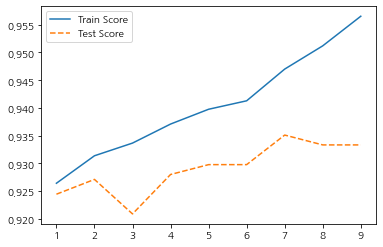

In [34]:
plt.plot(para_depth, train_score, linestyle="-", label = "Train Score")
plt.plot(para_depth, test_score, linestyle="--", label = "Test Score")
plt.legend()

In [35]:
df_score_depth.round(3)

,MaxDepth,TrainScore,TestScore
0,1,0.926,0.924
1,2,0.931,0.927
2,3,0.934,0.921
3,4,0.937,0.928
4,5,0.940,0.930
5,6,0.941,0.930
6,7,0.947,0.935
7,8,0.951,0.933
8,9,0.957,0.933


### 트리 그리기

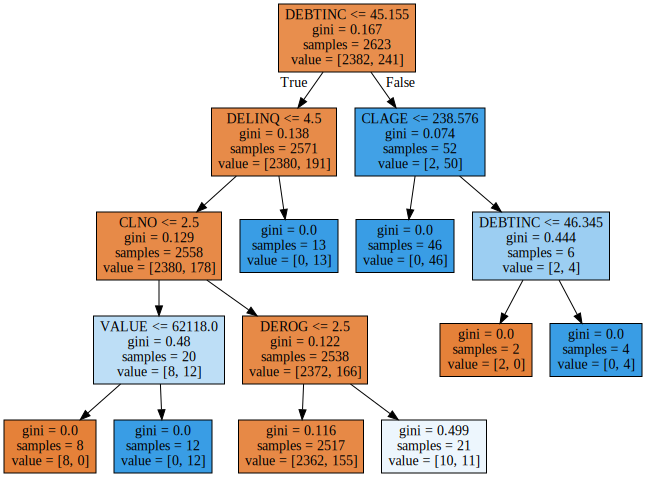

In [52]:
v_feature_name = df_train_x.columns

# 분리노드의 최소 자료수 설정
tree_graph = DecisionTreeClassifier(max_depth=4, random_state=1234)
tree_graph.fit(df_train_x, df_train_y)

## Tree 구조 생성 및 저장: 모델 시각화
export_graphviz(tree_graph, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### min_samples_split: 20으로 선정

In [44]:
train_score = []; test_score = []
para_split = [n_leaf * 10 for n_leaf in range(1, 11)]

for v_min_samples_split in para_split:
    tree = DecisionTreeClassifier(random_state=1234, max_depth=4,
                                 min_samples_split=v_min_samples_split)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_split = pd.DataFrame()
df_score_split["MinSamplesSplit"] = para_split
df_score_split["TrainScore"] = train_score
df_score_split["TestScore"] = test_score

In [42]:
df_score_split.round(3)

,MinSamplesSplit,TrainScore,TestScore
0,10,0.936,0.928
1,20,0.936,0.928
2,30,0.933,0.921
3,40,0.933,0.921
4,50,0.933,0.921
5,60,0.933,0.921
6,70,0.933,0.921
7,80,0.933,0.921
8,90,0.933,0.921
9,100,0.933,0.921


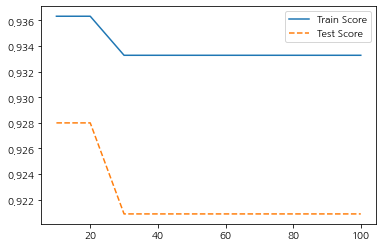

In [43]:
plt.plot(para_split, train_score, linestyle="-", label = "Train Score")
plt.plot(para_split, test_score, linestyle="--", label = "Test Score")
plt.legend()

### 트리 그리기

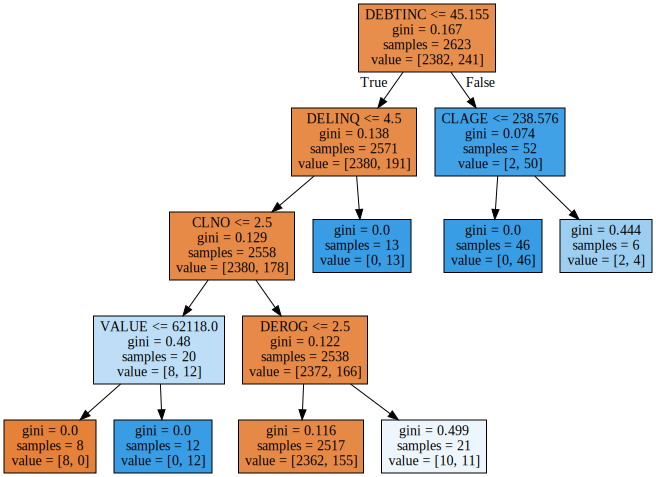

In [53]:
v_feature_name = df_train_x.columns

# 분리노드의 최소 자료수 설정
tree_graph = DecisionTreeClassifier(max_depth=4, min_samples_split=20, random_state=1234)
tree_graph.fit(df_train_x, df_train_y)

## Tree 구조 생성 및 저장: 모델 시각화
export_graphviz(tree_graph, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### Min_samples_leaf =  10으로 선정

In [47]:
train_score = []; test_score = []

para_leaf = [n_leaf * 2 for n_leaf in range(1, 11)]
for v_min_samples_leaf in para_leaf:
    tree = DecisionTreeClassifier(random_state=1234, min_samples_leaf=v_min_samples_leaf, 
                                 max_depth=4, min_samples_split=20)
    tree.fit(df_train_x, df_train_y)
    train_score.append(tree.score(df_train_x, df_train_y))
    test_score.append(tree.score(df_test_x, df_test_y))
    
# 결과 저장
df_score_leaf = pd.DataFrame()
df_score_leaf["MinSampleLeaf"] = para_leaf
df_score_leaf["TrainAccuracy"] = train_score
df_score_leaf["TestAccuracy"] = test_score

In [49]:
df_score_leaf.round(3)

,MinSampleLeaf,TrainAccuracy,TestAccuracy
0,2,0.936,0.928
1,4,0.936,0.928
2,6,0.936,0.928
3,8,0.936,0.928
4,10,0.936,0.928
5,12,0.933,0.921
6,14,0.932,0.917
7,16,0.932,0.919
8,18,0.932,0.919
9,20,0.932,0.919


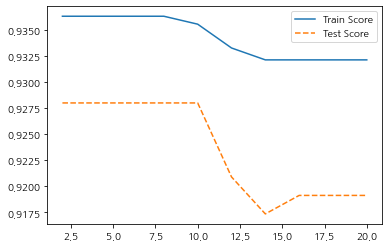

In [50]:
plt.plot(para_leaf, train_score, linestyle="-", label = "Train Score")
plt.plot(para_leaf, test_score, linestyle="--", label = "Test Score")
plt.legend()

### 트리 그리기

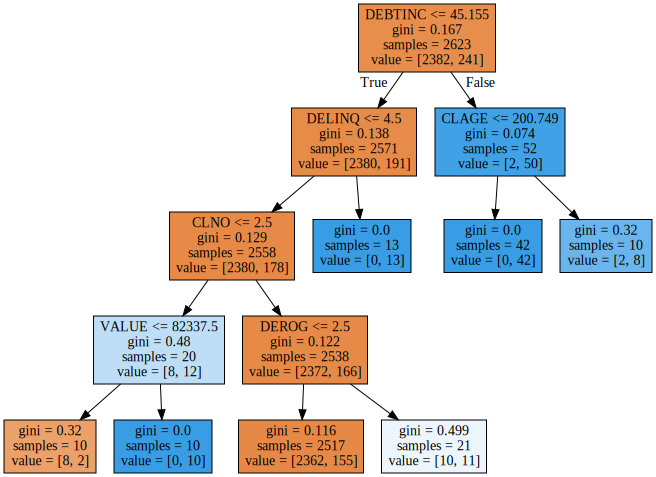

In [54]:
v_feature_name = df_train_x.columns

# 분리노드의 최소 자료수 설정 (노드 수 16)
tree_graph = DecisionTreeClassifier(max_depth=4, min_samples_leaf=10, min_samples_split=20,
                                    random_state=1234)
tree_graph.fit(df_train_x, df_train_y)

## Tree 구조 생성 및 저장: 모델 시각화
export_graphviz(tree_graph, out_file = "tree_leaf.dot", feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_leaf.dot") as f:
    dot_graph = f.read()
display(graphviz.Source(dot_graph))

### 하이퍼 파라미터 튜닝 결과
- 최대 깊이: 4
- min_sampled_split: 20
- min_samples_leaf:10


- 하이퍼 파라미터 튜닝의 결과는 어떤 변수를 먼저 튜닝하느냐에 따라 달라질 수 있다. 또한 분석가마다 차이가 있기 때문에 구체적인 기준 등은 없다고 할 수 있다. 또한 데이터의 양이 많아지거나, 변수의 종류가 많아지면, 하이퍼 파라미터의 값이 작다고 무조건 좋다고 할 수도 없다. 왜냐하면 설명력이 있는 모델을 만들어야 하기 때문이다. 

## 3. 최종 모델 선정

In [13]:
tree_final = DecisionTreeClassifier(min_samples_leaf= 10, min_samples_split=20, 
                                   max_depth=4,random_state=1234)
tree_final.fit(df_train_x, df_train_y)

# Train 데이터 설명력
print("Accuracy on training set: {:.3f}".format(tree_final.score(df_train_x, df_train_y)))
#test데이터 설명력
print("Accuracy on test set: {:.3f}".format(tree_final.score(df_test_x, df_test_y)))

Accuracy on training set: 0.936
Accuracy on test set: 0.928


- 초기에 검사했던 설명력 점수보다는 확실히 트레이닝 데이터의 과적합이 줄어들었음을 확인할 수 있다. 반면에 테스트 데이터의 점수는 거의 변동이 없어서, 튜닝이 잘 되었다고 할 수 있다.

### 최종모델 시각화

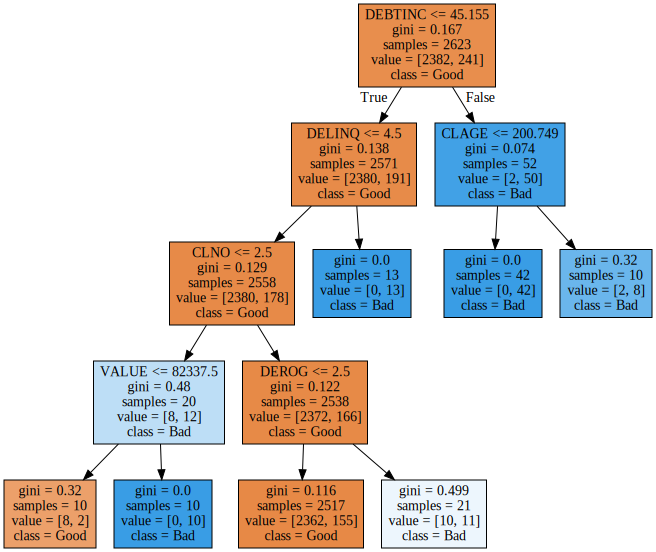

In [14]:
v_feature_name = df_train_x.columns

## Tree 구조 생성 및 저장: 모델 시각화
tree_graph = tree_final
tree_graph.fit(df_train_x, df_train_y)

# class 이름을 추가 
export_graphviz(tree_graph, out_file = "tree_final.dot", class_names=["Good", "Bad"],
                feature_names = v_feature_name,
                impurity=True, filled = True) # filled 색으로 영향력 표시

with open("tree_final.dot") as f:
    dot_graph = f.read()
    
display(graphviz.Source(dot_graph))

### 최종모델 평가
- 트리 분리에 가장 큰 영향을 미치는 변수는 DEBTINC, CLAGE, DELINQ라고 할 수 있다.
- 부채비율(DEBTINC)이 <= 45.155이면 True이고, 45.155이상이면 False이다.

- 부채비율 > 45.155 & 최장계좌 연속 월(CLAGE) <=224.425이면 전체 데이터가 Bad(불이행)로 분리 된다.
    - 자료수 = 44, Bad비율 = 100%, gini지수 = 0
   
   
- 고객의 입장에서 부채비율이 45.155보다 크고, 최장계좌 연속월이 작은 사람은 돈을 잘 갚지 않는다고 판단되어 돈을 빌리기 힘들 수 있다.

### 최종 모델을 이용한 분류 예측

In [70]:
y_pred = tree_final.predict(df_test_x)

print("Accuracy:{0:.3f}\n".format(tree_final.score(df_test_x, df_test_y)))
print("Confusion Matrix: \n{}".format(confusion_matrix(df_test_y, y_pred)))

Accuracy:0.928

Confusion Matrix: 
[[1015    6]
 [  75   29]]


- 정분류율 92.8%이다.

### 결론도출_설명변수의 중요도

In [71]:
df_importance = pd.DataFrame()
df_importance["Feature"]=v_feature_name
df_importance["Importance"] = tree_final.feature_importances_

df_importance.sort_values("Importance", ascending=False, inplace = True)
df_importance.round(3)

,Feature,Importance
9,DEBTINC,0.618
5,DELINQ,0.172
8,CLNO,0.087
4,DEROG,0.068
2,VALUE,0.049
6,CLAGE,0.005
12,JOB_Mgr,0.000
16,JOB_Sales,0.000
15,JOB_ProfExe,0.000
14,JOB_Other,0.000


Text(0, 0.5, '변수')

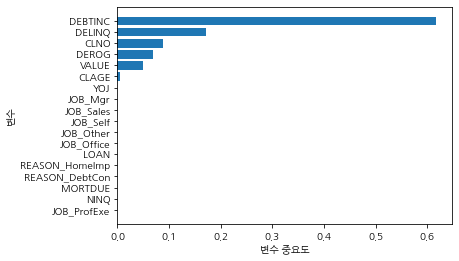

In [72]:
df_importance.sort_values("Importance", ascending= True, inplace=True)
coordinates=range(len(df_importance))
plt.barh(y=coordinates, width = df_importance["Importance"])
plt.yticks(coordinates, df_importance["Feature"])
plt.xlabel("변수 중요도")
plt.ylabel("변수")

- 중요 설명변수: 트리 생성 시 부채비율(DEBTINC), 연체된 신용 한도의 수(DELINQ) 순으로 영향이 크다고 해석할 수 있음
- 단, 계산된 변수 중요도 값이 낮거나 0이더라도 선택되는 훈련 데이터에 따라 중요도는 변경될 가능성이 있다.
- 따라서 변수 중요도가 낮다고 꼭 필요없는 데이터는 아니라는 것이다.